# Compute efficiency distributions for a proton sample

In [1]:
import ROOT
from os import path
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.14/09


### Proton reconstruction flavors

There are two ways to reconstruct protons in PPS: _single-RP_ and _multi-RP_
The flag below controls which proton reconstruction is used.

In the single-RP reconstruction, the proton kinematics is only partially reconstructed from a single detector station. 
In the multi-RP reconstruction, both "near" and "far" tracking detector stations in one spectrometer arm are used. 

The second is more accurate, at the cost of acceptance. In this exercise we will see how to retrieve efficiency corrections in for multiRP protons. 

We will work on a MC file with quite large statistics and apply the corrections needed to compare it with data taken in the **2017B** period

In [2]:
data_folder = "root://cmseos.fnal.gov//store/user/cmsdas/2022/short_exercises/pps-protons-tutorial/data/"
fileName_signal = data_folder+"output-MC2017-Elastic-Non3+3-PreSel.h5"

#fileName_data = data_folder+"data/output-UL2017B-PreSel.h5"
#fileName_data = data_folder+"data/output-UL2017C1-PreSel.h5"
#fileName_data = data_folder+"data/output-UL2017F1-PreSel.h5"

#proton_selection = "SingleRP"
proton_selection = "MultiRP"

## Access the MC

In [3]:
df_signal = None
event_counts_signal = None
selections_str_signal = None

#copy the file to local area (if needed)
if not path.isfile(path.basename(fileName_signal)): 
    !xrdcopy {fileName_signal} .

print('Loading data from '+path.basename(fileName_signal)+'...')
with h5py.File( path.basename(fileName_signal), 'r' ) as f:
    #print ( list(f.keys()) )
    dset = f['protons']
    print ( 'dataset size = '+str(dset.shape) )
    #print ( dset[:,:] )
    dset_columns = f['columns']
    #print ( dset_columns.shape )
    columns = list( dset_columns )
    #print ( columns )
    columns_str = [ item.decode("utf-8") for item in columns ]
    #print ( columns_str )

    df_signal = pd.DataFrame( dset, columns=columns_str )
    
    df_signal = df_signal[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                            'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                            'Xi', 'T', 'ThX', 'ThY',
                            'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )

print('Data loaded!')    

Loading data from output-MC2017-Elastic-Non3+3-PreSel.h5...
dataset size = (213536, 38)
Data loaded!


### Proton efficiency extraction

We will evaluate the efficiency correction for _multi-RP_ protons. 

This has to be computed as the product of the efficiency of the "210 Far" detector station (silicon strips, in 2017) and the "multiRP efficiency".

The efficiency components for the strips is divided in two parts: multitrack and sensor. 
The former accounts the inefficiency caused by strips detectors not being able to reconstruct multiple tracks in the same event. This is a single numeric factor.
The sensor efficiency takes into account local inefficiencies caused, e.g., by radiation damage and is supplied as a 2D, xy map. 

The multiRP efficiency accounts instead for both the sensor efficiency of the 220 Far RP (pixels in 2017 and 2018) and the inefficiency component given by the proton chance of interacting while travelling from the near to the far RP. Again, this is supplied as a 2D, xy map.

A different measurement is available for each data period here included: 2017B, 2017C1, 2017F1.

Despite being counter-intuitive, it should be noted that, for 210 Far RP efficiencies one should use the xy coordinates measured in the 220 Far RP (TrackX2/TrackY2) and for multiRP the ones measured in the 210 Far RP (TrackX1/TrackY1). This is a consequence of the Tag&Probe method used to produce the efficiency corrections.

In [4]:
# Efficiency correction files
strips_efficiency_file = ROOT.TFile.Open("root://cmseos.fnal.gov//store/user/cmsdas/2022/short_exercises/pps-protons-tutorial/PreliminaryEfficiencies_July132020_1D2DMultiTrack.root")
multiRP_efficiency_file = ROOT.TFile.Open("root://cmseos.fnal.gov//store/user/cmsdas/2022/short_exercises/pps-protons-tutorial/pixelEfficiencies_multiRP.root")

data_taking_period = "2017B"
year = data_taking_period[:4]

strips_multitrack_efficiency = {}
strips_sensor_efficiency = {}
multiRP_efficiency = {}

# Retrieve histograms from files and save them in dictionaries for future usage
for sector in ["45","56"]:
    rp_number = "3" if sector == "45" else "103"
    strips_multitrack_efficiency[sector] = strips_efficiency_file.Get("Strips/"+year+"/"+data_taking_period+"/h"+sector+"multitrackeff_"+data_taking_period+"_avg_RP"+rp_number).GetBinContent(1)
    strips_sensor_efficiency[sector] = strips_efficiency_file.Get("Strips/"+year+"/"+data_taking_period+"/h"+sector+"_"+data_taking_period+"_all_2D")
    multiRP_efficiency[sector] = multiRP_efficiency_file.Get("Pixel/"+year+"/"+data_taking_period+"/h"+sector+"_220_"+data_taking_period+"_all_2D")

In [5]:
# Select only multiRP protons from dataframe
df_multiRP = df_signal[df_signal["MultiRP"] == 1]

# Create column for the efficiency
proton_strips_multitrack_efficiency = []
proton_strips_sensor_efficiency = []
proton_multiRP_efficiency = []
for row_n,row in df_multiRP.iterrows():
    sector = "45" if row["Arm"] == 0 else "56"
    proton_strips_multitrack_efficiency.append(strips_multitrack_efficiency[sector])
    proton_strips_sensor_efficiency.append(strips_sensor_efficiency[sector].GetBinContent(strips_sensor_efficiency[sector].FindBin(row["TrackX2"],row["TrackY2"])))
    proton_multiRP_efficiency.append(multiRP_efficiency[sector].GetBinContent(multiRP_efficiency[sector].FindBin(row["TrackX1"],row["TrackY1"])))

In [6]:
# Add efficiency column to the new multiRP protons dataframe
df_multiRP_withEfficiency = df_multiRP.copy()
df_multiRP_withEfficiency["Strips_multitrack_efficiency"] = proton_strips_multitrack_efficiency 
df_multiRP_withEfficiency["Strips_sensor_efficiency"] = proton_strips_sensor_efficiency
df_multiRP_withEfficiency["MultiRP_efficiency"] = proton_multiRP_efficiency
df_multiRP_withEfficiency["Efficiency"] = df_multiRP_withEfficiency["Strips_multitrack_efficiency"] * df_multiRP_withEfficiency["Strips_sensor_efficiency"] * df_multiRP_withEfficiency["MultiRP_efficiency"]

In [7]:
# Show a few lines of the new dataframe
df_multiRP_withEfficiency[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,Strips_multitrack_efficiency,Strips_sensor_efficiency,MultiRP_efficiency,Efficiency
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,114.552933,251.395355,16,0.000880,0.004588,0.081510,0.635052,0.871239,0.836506,0.462824
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,52.814793,126.690613,4,0.001160,0.055618,0.001708,0.640792,0.818589,0.876536,0.459783
16,1,1,17,150.0,1,1,103,123,3.828247,0.749878,...,60.853138,263.130524,1,0.000028,0.008177,0.050104,0.635052,0.848024,0.821312,0.442309
19,1,1,30,150.0,1,0,3,23,5.139893,0.158340,...,51.576660,176.417725,1,0.001032,0.046055,0.003999,0.640792,0.817628,0.865898,0.453669
24,1,1,13,150.0,1,1,103,123,2.742798,0.001996,...,115.790192,233.975662,17,0.000317,0.007711,0.042010,0.635052,0.767814,0.784895,0.382716
27,1,1,31,150.0,1,1,103,123,5.258789,-0.745728,...,72.441437,266.681091,0,0.001807,0.006805,0.061971,0.635052,0.864215,0.851786,0.467478
30,1,1,37,150.0,1,0,3,23,4.975342,1.117432,...,66.498047,176.964508,0,0.000757,0.054292,0.003414,0.640792,0.762946,0.881788,0.431097
42,1,1,52,150.0,1,0,3,23,7.566895,0.678040,...,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.640792,0.814197,0.894277,0.466572
43,1,1,52,150.0,1,1,103,123,11.388184,3.717285,...,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.635052,0.887046,0.874307,0.492515
46,1,1,57,150.0,1,1,103,123,3.813232,1.491821,...,56.575214,115.234695,0,0.000651,0.001538,0.051120,0.635052,0.856338,0.833857,0.453467


### Plot the efficiency vs. Xi distributions

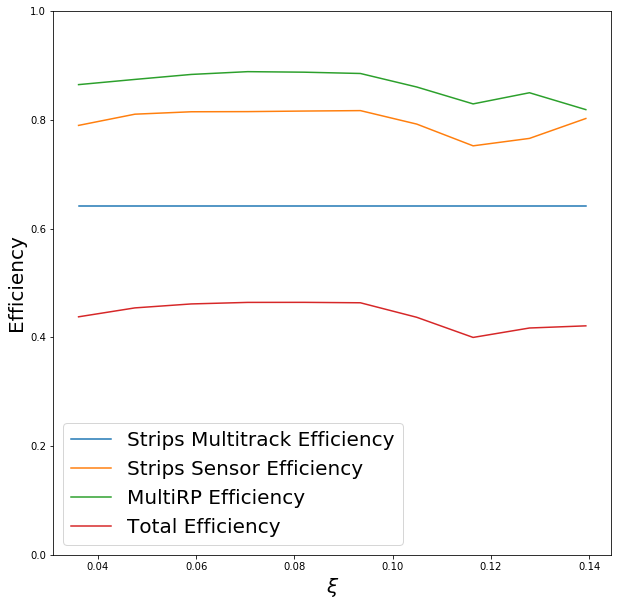

In [8]:
fig, axis = plt.subplots(figsize=(10,10))
n_bins = 10
arm = 0

# Select only protons with Arm == 0
df_multiRP_withEfficiency_arm = df_multiRP_withEfficiency[df_multiRP_withEfficiency["Arm"] == arm]

# Bin data depending on xi -> xi_counts = bin content
xi_counts, xi_bins = np.histogram( df_multiRP_withEfficiency_arm["Xi"], bins=n_bins)

# Get bin contents while weighting on the strips multitrack efficiency of each entry
strips_multitrack_efficiency_counts, _ = np.histogram( df_multiRP_withEfficiency_arm["Xi"], bins=n_bins,weights=df_multiRP_withEfficiency_arm["Strips_multitrack_efficiency"])
# Get bin contents while weighting on the strips sensor efficiency of each entry
strips_sensor_efficiency_counts, _ = np.histogram( df_multiRP_withEfficiency_arm["Xi"], bins=n_bins,weights=df_multiRP_withEfficiency_arm["Strips_sensor_efficiency"])
# Get bin contents while weighting on the multiRP efficiency of each entry
multiRP_efficiency_counts, _ = np.histogram( df_multiRP_withEfficiency_arm["Xi"], bins=n_bins,weights=df_multiRP_withEfficiency_arm["MultiRP_efficiency"])

# Compute bin centers and averages
xi_bin_centers = [(xi_bins[i] + xi_bins[i+1])/2 for i in range(len(xi_bins)-1)]
strips_multitrack_avg_efficiency_counts = strips_multitrack_efficiency_counts / xi_counts
strips_sensor_avg_efficiency_counts = strips_sensor_efficiency_counts / xi_counts
multiRP_avg_efficiency_counts = multiRP_efficiency_counts / xi_counts
total_efficiency = strips_multitrack_avg_efficiency_counts * strips_sensor_avg_efficiency_counts * multiRP_avg_efficiency_counts

# Plot efficiencies
axis.plot(xi_bin_centers,strips_multitrack_avg_efficiency_counts, label="Strips Multitrack Efficiency")
axis.plot(xi_bin_centers,strips_sensor_avg_efficiency_counts, label="Strips Sensor Efficiency")
axis.plot(xi_bin_centers,multiRP_avg_efficiency_counts, label="MultiRP Efficiency")
axis.plot(xi_bin_centers,total_efficiency, label="Total Efficiency")


# Add labels and legend
ylim = axis.set_ylim([0,1])
axis.set_ylabel( "Efficiency", fontsize=20 )
axis.set_xlabel( r"$\xi$", fontsize=20 )
l = plt.legend(fontsize=20)